<a href="https://colab.research.google.com/github/partheee/Detecto-/blob/main/Automated_dataset_annotation_and_evaluation_with_grounding_dino_and_sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Apr 20 20:17:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant. 

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Grounding DINO and Segment Anything Model

Our project will use two groundbreaking designs - [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) - for zero-shot detection and [Segment Anything Model (SAM)](https://github.com/facebookresearch/segment-anything) - for converting boxes into segmentations. We have to install them first.


In [3]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 270 (delta 19), reused 17 (delta 17), pack-reused 226
Receiving objects: 100% (270/270), 12.34 MiB | 13.48 MiB/s, done.
Resolving deltas: 100% (123/123), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.1 MB/s eta 0:00:00


In [4]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-8adxd6lf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-8adxd6lf
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=9b8154309d5f3c29de1821d1add308dda098ede66d7ec9532ccf77d1314f8844
  Stored in directory: /tmp/pip-ephem-wheel-cache-o6wk_cs2/wheels/d5/11/03/7aca746a2c0e09f279b10436ced7175926bc38f650b736a648
Successfully built segment-anything


**NOTE:** To glue all the elements of our demo together we will use the [`supervision`](https://github.com/roboflow/supervision) pip package, which will help us **process, filter and visualize our detections as well as to save our dataset**. A lower version of the `supervision` was installed with Grounding DINO. However, in this demo we need the functionality introduced in the latest versions. Therefore, we uninstall the current `supervsion` version and install version `0.6.0`.



In [5]:
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

Found existing installation: supervision 0.4.0
Uninstalling supervision-0.4.0:
  Successfully uninstalled supervision-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.
0.6.0


### Download Grounding DINO Model Weights

To run Grounding DINO we need two files - configuration and model weights. The configuration file is part of the [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) repository, which we have already cloned. The weights file, on the other hand, we need to download. We write the paths to both files to the `GROUNDING_DINO_CONFIG_PATH` and `GROUNDING_DINO_CHECKPOINT_PATH` variables and verify if the paths are correct and the files exist on disk.

In [7]:
import os

GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [8]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [9]:
import os

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


### Download Segment Anything Model (SAM) Weights

As with Grounding DINO, in order to run SAM we need a weights file, which we must first download. We write the path to local weight file to `SAM_CHECKPOINT_PATH` variable and verify if the path is correct and the file exist on disk.

In [10]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [11]:
import os

SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Load models

In [12]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Grounding DINO Model

In [13]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/content/GroundingDINO


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Load Segment Anything Model (SAM)

In [14]:
SAM_ENCODER_VERSION = "vit_h"

In [15]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

In [16]:
f"{HOME}/data"

'/content/data'

## Single Image Mask Auto Annotation

Before we automatically annotate the entire dataset let's focus for a moment on a single image.

In [47]:
SOURCE_IMAGE_PATH = f"{HOME}/data/ecl_3.png"
CLASSES = ['person', 'hat']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.15

### Zero-Shot Object Detection with Grounding DINO

**NOTE:** To get better Grounding DINO detection we will leverage a bit of prompt engineering using `enhance_class_name` function defined below. 👇 You can learn more from our [Grounding DINO tutorial](https://blog.roboflow.com/grounding-dino-zero-shot-object-detection/).

In [48]:
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

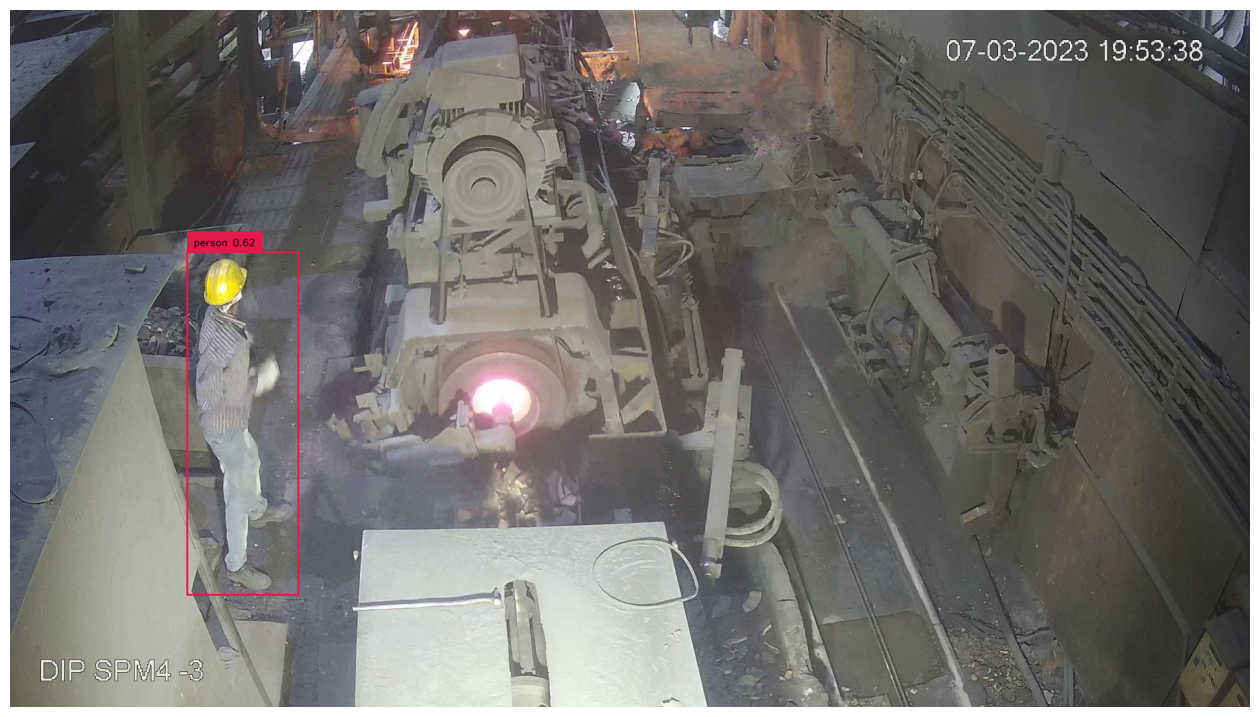

In [49]:
import cv2
import supervision as sv

# load image
image = cv2.imread(SOURCE_IMAGE_PATH)

# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _ 
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

### Prompting SAM with detected boxes

In [50]:
import numpy as np
from segment_anything import SamPredictor


def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

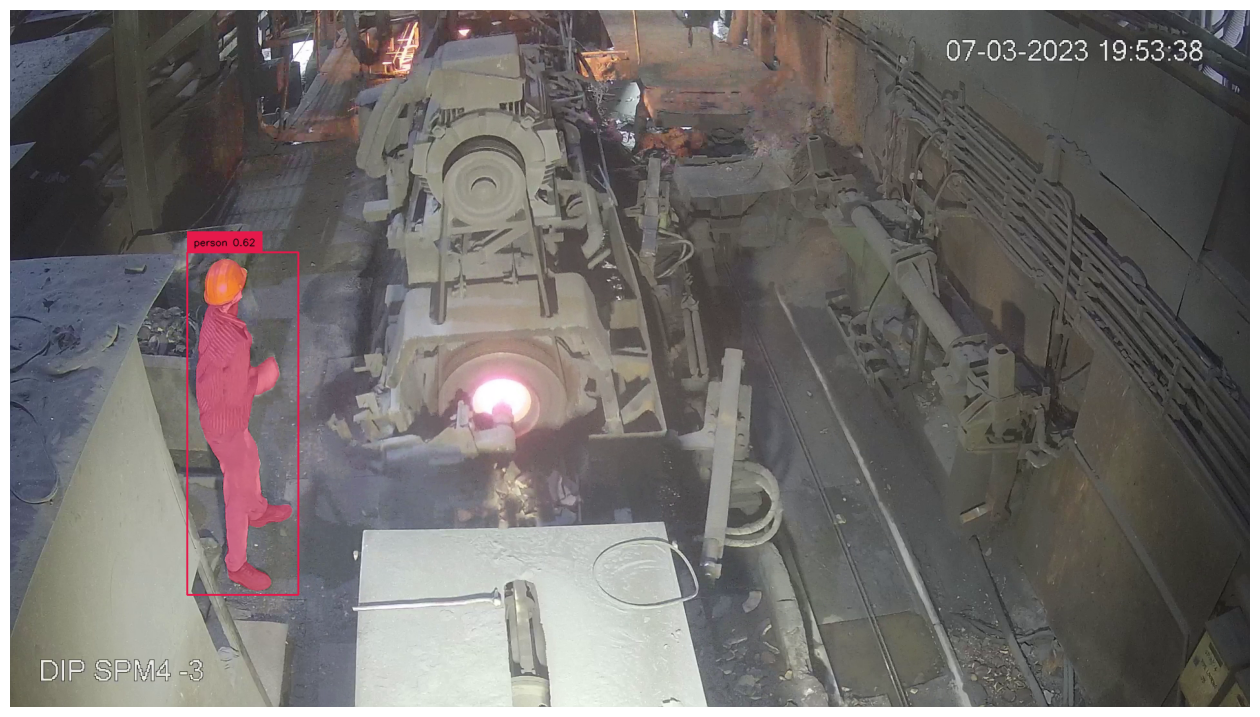

In [51]:
import cv2

# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _ 
    in detections]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

AttributeError: ignored

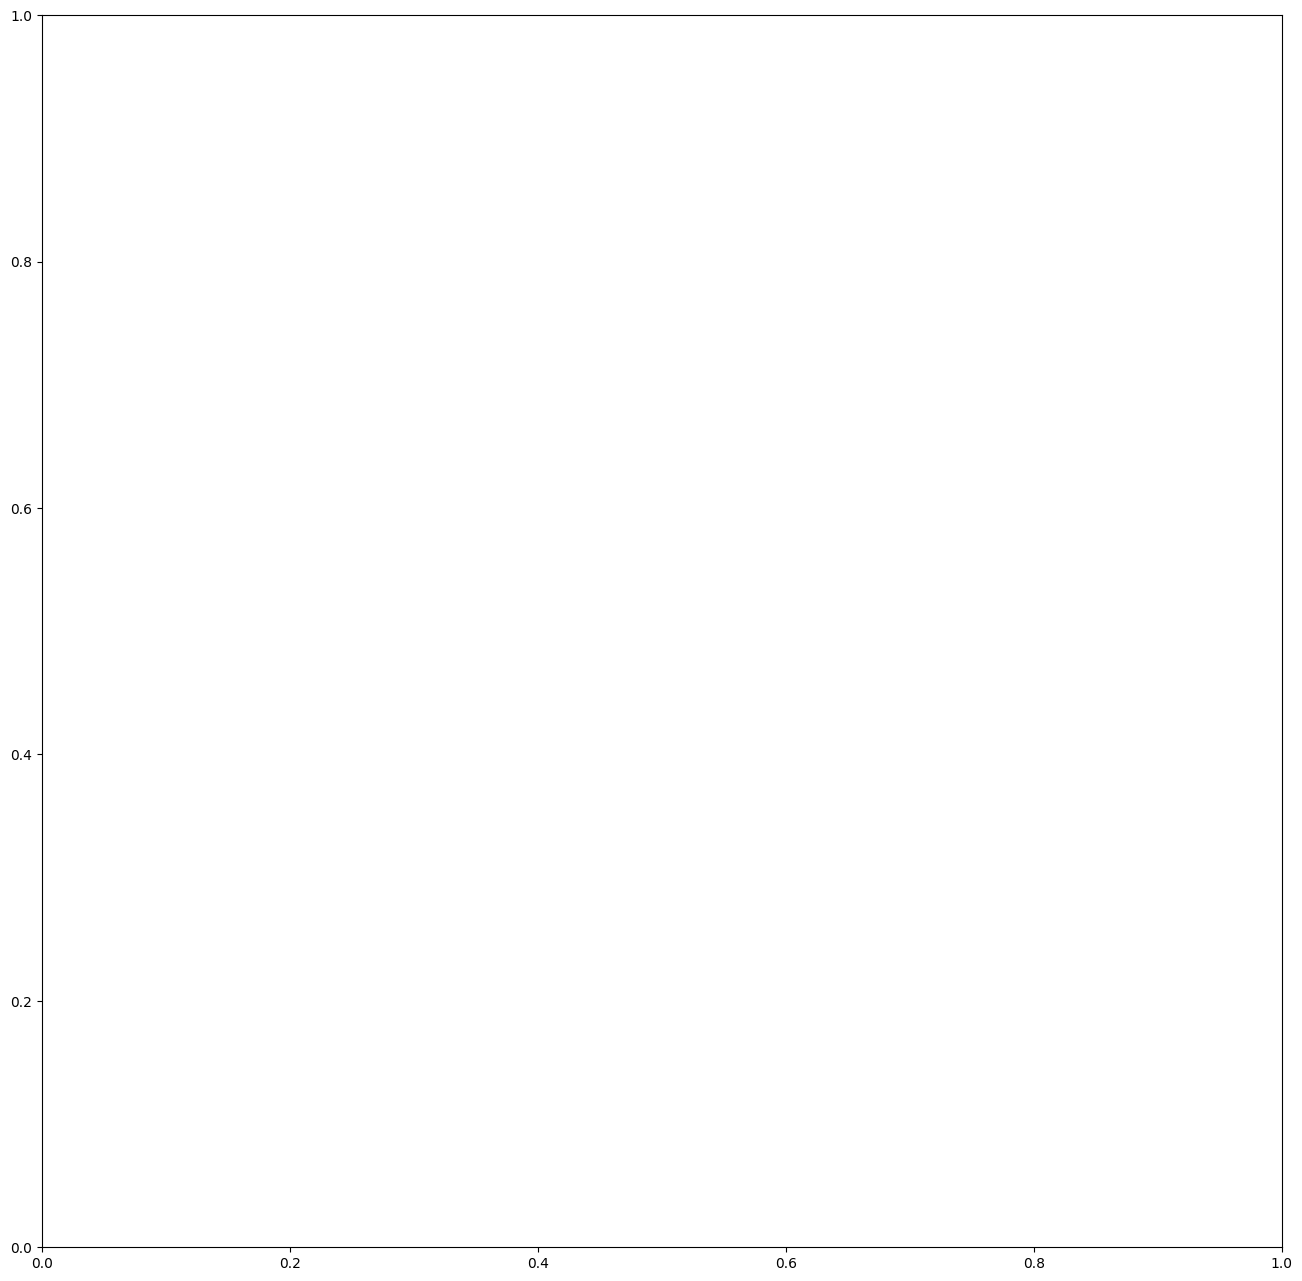

In [52]:
import math

grid_size_dimension = math.ceil(math.sqrt(len(detections.mask)))

titles = [
    CLASSES[class_id]
    for class_id
    in detections.class_id
]

sv.plot_images_grid(
    images=detections.mask,
    titles=titles,
    grid_size=(grid_size_dimension, grid_size_dimension),
    size=(16, 16)
)

## Full Dataset Mask Auto Annotation

In [56]:
import os

IMAGES_DIRECTORY = os.path.join(HOME, 'data')
IMAGES_EXTENSIONS = ['jpg', 'jpeg', 'png']

CLASSES = ['person']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.15

### Extract labels from images

In [57]:
import cv2
from tqdm.notebook import tqdm

images = {}
annotations = {}

image_paths = sv.list_files_with_extensions(
    directory=IMAGES_DIRECTORY, 
    extensions=IMAGES_EXTENSIONS)

for image_path in tqdm(image_paths):
    image_name = image_path.name
    image_path = str(image_path)
    image = cv2.imread(image_path)

    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    detections = detections[detections.class_id != None]
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )
    images[image_name] = image
    annotations[image_name] = detections

  0%|          | 0/6 [00:00<?, ?it/s]

**NOTE:** Before we save our `Detections` in Pascal VOC XML format, let's take a peek at the annotations we obtained. This step is optional, feel free to skip it.

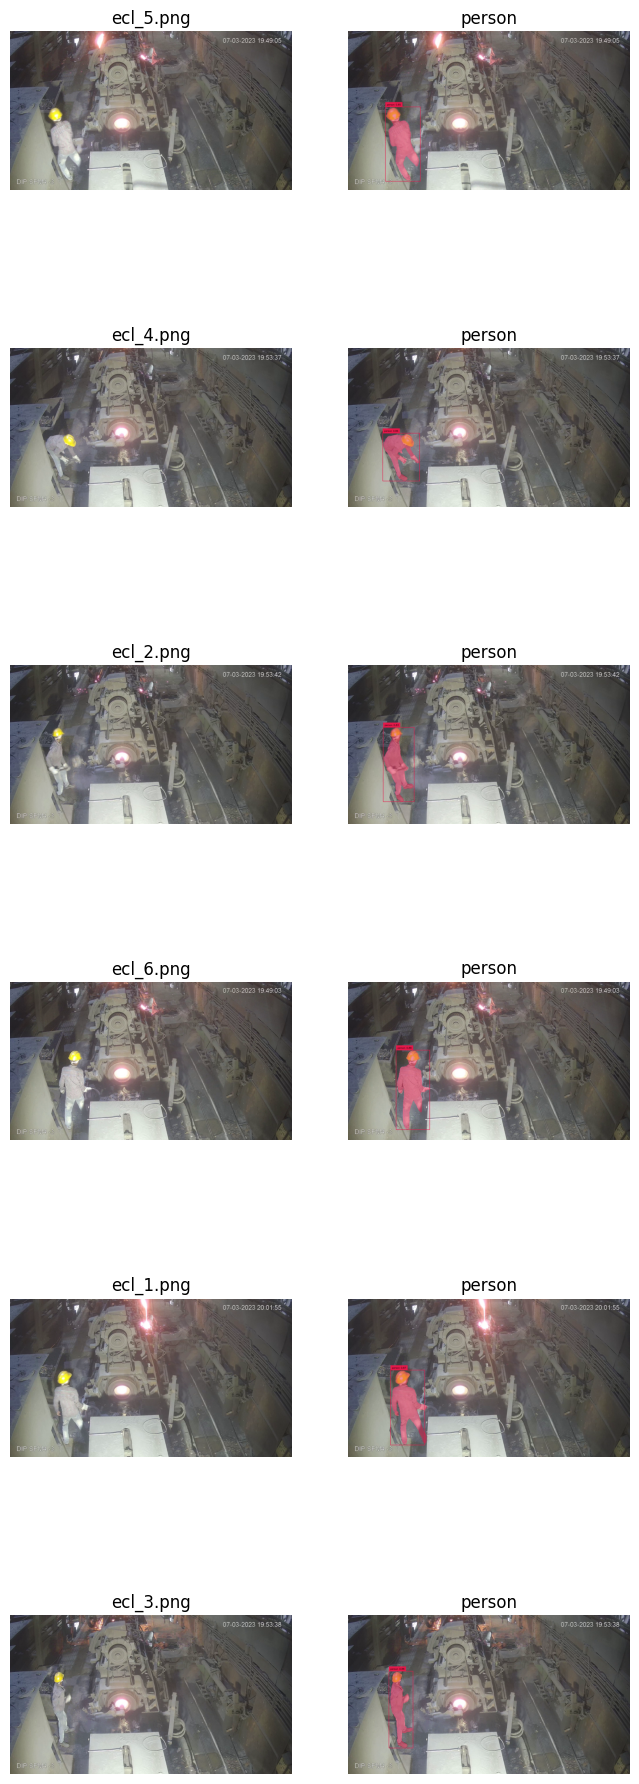

In [58]:
plot_images = []
plot_titles = []

box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()

for image_name, detections in annotations.items():
    image = images[image_name]
    plot_images.append(image)
    plot_titles.append(image_name)

    labels = [
        f"{CLASSES[class_id]} {confidence:0.2f}" 
        for _, _, confidence, class_id, _ 
        in detections]
    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
    plot_images.append(annotated_image)
    title = " ".join(set([
        CLASSES[class_id]
        for class_id
        in detections.class_id
    ]))
    plot_titles.append(title)

sv.plot_images_grid(
    images=plot_images,
    titles=plot_titles,
    grid_size=(len(annotations), 2),
    size=(2 * 4, len(annotations) * 4)
)

### Save labels in Pascal VOC XML

In [59]:
ANNOTATIONS_DIRECTORY = os.path.join(HOME, 'annotations')

MIN_IMAGE_AREA_PERCENTAGE = 0.002
MAX_IMAGE_AREA_PERCENTAGE = 0.80
APPROXIMATION_PERCENTAGE = 0.75

In [60]:
sv.Dataset(
    classes=CLASSES,
    images=images,
    annotations=annotations
).as_pascal_voc(
    annotations_directory_path=ANNOTATIONS_DIRECTORY,
    min_image_area_percentage=MIN_IMAGE_AREA_PERCENTAGE,
    max_image_area_percentage=MAX_IMAGE_AREA_PERCENTAGE,
    approximation_percentage=APPROXIMATION_PERCENTAGE
)